<a href="https://colab.research.google.com/github/Hernanros/Y_Data_DL/blob/HW%234-answers/%5BHW%234%20super%20resulutaion%20FCN%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar

--2020-04-16 08:51:39--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar.1’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  12.7MB/s    in 37s     

2020-04-16 08:52:16 (11.9 MB/s) - ‘VOCtrainval_06-Nov-2007.tar.1’ saved [460032000/460032000]



In [23]:
! tar -xvf VOCtrainval_06-Nov-2007.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2007/JPEGImages/001733.jpg
VOCdevkit/VOC2007/JPEGImages/001734.jpg
VOCdevkit/VOC2007/JPEGImages/001738.jpg
VOCdevkit/VOC2007/JPEGImages/001739.jpg
VOCdevkit/VOC2007/JPEGImages/001741.jpg
VOCdevkit/VOC2007/JPEGImages/001746.jpg
VOCdevkit/VOC2007/JPEGImages/001747.jpg
VOCdevkit/VOC2007/JPEGImages/001749.jpg
VOCdevkit/VOC2007/JPEGImages/001750.jpg
VOCdevkit/VOC2007/JPEGImages/001752.jpg
VOCdevkit/VOC2007/JPEGImages/001754.jpg
VOCdevkit/VOC2007/JPEGImages/001755.jpg
VOCdevkit/VOC2007/JPEGImages/001756.jpg
VOCdevkit/VOC2007/JPEGImages/001758.jpg
VOCdevkit/VOC2007/JPEGImages/001759.jpg
VOCdevkit/VOC2007/JPEGImages/001761.jpg
VOCdevkit/VOC2007/JPEGImages/001765.jpg
VOCdevkit/VOC2007/JPEGImages/001766.jpg
VOCdevkit/VOC2007/JPEGImages/001768.jpg
VOCdevkit/VOC2007/JPEGImages/001771.jpg
VOCdevkit/VOC2007/JPEGImages/001772.jpg
VOCdevkit/VOC2007/JPEGImages/001775.jpg
VOCdevkit/VOC2007/JPEGImages/001777.jpg
VOCdevkit/VOC2007/JPEGImages/

In [0]:
import glob 
# initialize a list of file paths for photos
photos= glob.glob('/content/VOCdevkit/VOC2007/JPEGImages/*.jpg')

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

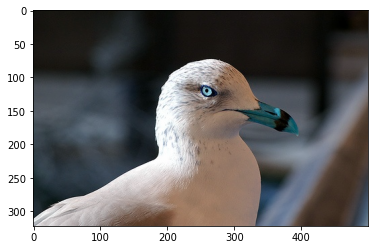

In [26]:
plt.imshow(cv2.imread(photos[0]))

In [0]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [0]:
# samples random 10 images to play with from raw data
np.random.set_state = 42
mini_dataset_ind = np.random.choice(len(photos),100,False)
sample = []
[sample.append(cv2.imread(photos[ind])) for ind in mini_dataset_ind]
sample = np.array(sample)

In [0]:
# create 3 different photosizes datasets out of the raw data of sizes (288,288),(144,144),(72,72)

x_train = [cv2.resize(sample[ind] , (72,72)) for ind in range(len(sample))]
y_mid = [cv2.resize(sample[ind] , (144,144)) for ind in range(len(sample))]
y_large = [cv2.resize(sample[ind] , (288,288)) for ind in range(len(sample))]


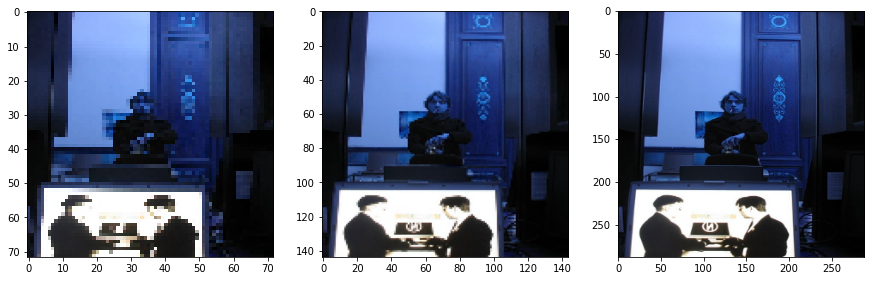

In [30]:
i = np.random.randint(100)

f,ax = plt.subplots(1, 3, figsize= (15,5))
ax[0]=plt.subplot(1,3,1)
ax[0]= plt.imshow(x_train[i])

ax[1]=plt.subplot(1,3,2)
ax[1]= plt.imshow(y_mid[i])

ax[2]=plt.subplot(1,3,3)
ax[2]= plt.imshow(y_large[i])

In [0]:
inds = np.random.choice(100,100,False)

X_train, y_mid_train, y_large_train = np.array(x_train)[inds[:80]], np.array(y_mid)[inds[:80]], np.array(y_large)[inds[:80]]

X_test, y_mid_test, y_large_test = np.array(x_train)[inds[80:]], np.array(y_mid)[inds[80:]], np.array(y_large)[inds[80:]]

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#augmentation library
import albumentations as A

In [0]:
 class DS(Dataset):
    def __init__(self,df,labels, transforms=None):
        super().__init__()
        self.df=df
        self.labels=labels
        self.transforms=transforms
 
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img= self.df[idx]
        label = self.labels[idx]        
        if not self.transforms is None:
            transformed_img = self.transforms(image=img)
            img = transformed_img['image']
        return img,label
        

In [0]:
train_set = DS(X_train,y_mid_train)
test_set= DS(X_test,y_mid_test)

train_loader=DataLoader(dataset= train_set, batch_size = 4, shuffle = True, num_workers = 2)
test_loader=DataLoader(dataset= test_set, batch_size = 4, shuffle = True, num_workers = 2)

In [0]:
class firstmodel(nn.Module):
  
  def __init__(self,in_channels = 3, out_channels = 3, num_filters = 64, kernel_size = 3, stride = 1 , padding = 1, keep_probab = 0.4):
    '''
    input : tensor of dimensions (batch_size*72*72*3)
    output: tensor of dimension (batchsize*144*144*3)
    4 blocks:
      1. 2d conv with 64 filters, kernel size 3*3 (one padding=1); input  (batch_size*72*72*3), output (batchsize*72*72*64)
      2. 2d conv with 64 filters, kernel size 3*3 (one padding=1);  (batch_size*72*72*64) output (batchsize*72*72*64)
      3. upsampling 2d; input (batchsize*72*72*64), output (batchsize*144*144*64)
      4. 2d conv with 3 filters (RGB), kernel size 1*1; input (batch_size*144*144*64), output (batchsize*144*144*3)

    '''
    super().__init__()
  
    
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.num_filters = num_filters
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = int(padding)
    self.keep_probab= keep_probab
      
    self.conv1 = nn.Conv2d(self.in_channels, self.num_filters, self.kernel_size, self.stride, self.padding )
    self.conv2 = nn.Conv2d(self.num_filters, self.num_filters, self.kernel_size, self.stride, self.padding )
    self.upsampling = nn.Upsample((144,144), mode= 'bilinear')
    self.dropout = nn.Dropout(self.keep_probab)
    self.pool = nn.MaxPool2d(2, 2)
    self.label = nn.Conv2d(self.num_filters, self.out_channels, 1, self.stride)
    self.norm = nn.BatchNorm2d(self.num_filters)


  def forward(self, x):
    x= x.permute(0, 3, 1, 2)
    x = self.pool(F.relu(self.norm(self.conv1(x))))
    x = self.pool(F.relu(self.norm(self.conv2(x))))
    x = self.upsampling(x)
    x = self.label(x)
    return x.permute(0,2,3,1)

### loss evaluation
PSNR loss function that evaluates the mean square loss per pixle (l2 loss).<br>
$$PSNR_{l2} = \frac{1}{mn}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1}[I(i,j)-K(i,j)]^2$$
where I is the ground truth and K is the recostructed image<br>

other variations of PSNR loss functions consider using l1 loss (Mean Absolute error) as the loss function<br>
$$ PSNR_{l1} = \frac{1}{mn}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1}|I(i,j)-K(i,j)|$$

In [0]:
import fuckers as ssi
model=firstmodel()
l2 = nn.MSELoss()
l1= nn.L1Loss()
criterion = ssi.ssim
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:


    
def train_epoch (tr_loader,model,criterion,optimizer, num_epochs):
    if torch.has_cuda:
      device = torch.device('cuda:0')
    
    else:
      device = torch.device('cpu:0')
    
    model.to(device)
    
    training_log =[]

    
    for epoch in range(num_epochs):
      print("started training epoch no. {}".format(epoch+1))
      tr_loss = 0
      for step,batch in enumerate(tr_loader):
            imgs, labels = batch
            imgs=imgs.to(device,dtype=torch.float32)
            labels = labels.to(device,dtype=torch.float32)
            outputs = model(imgs)
            loss = 1-criterion(outputs, labels, window_size=12)
            loss.backward()
            tr_loss+=loss.item()
            optimizer.step()
            optimizer.zero_grad()

      training_log.append({
                'epoch':epoch,
                'train_loss':tr_loss / len(tr_loader),
                })
      
    return training_log




def test_evaluation(tst_loader,model,losses):  
    model.eval()

    loss_ssim = 0
    loss_mse = 0
    loss_mae = 0
    N=0

    for step,batch in enumerate(tst_loader):
        imgs, labels = batch
        
        
        imgs = imgs.to(device,dtype=torch.float32)
        labels = labels.to(device,dtype=torch.float32)
        outputs = model(imgs)

        loss_ssim += 1-losses[0](outputs,labels, window_size=12).item()
        loss_mse += losses[1](outputs,labels).item()
        loss_mae += losses[2](outputs,labels).item()
        N += len(batch)
    f,ax = plt.subplots(batch[0].shape[0], 3 ,figsize = (5*batch[0].shape[0],15) )
    
    imgs , labels= imgs.cpu().detach().numpy().astype(int), labels.cpu().detach().numpy().astype(int)
    outputs_hats = np.abs(outputs.cpu().detach().numpy().astype(int))

    for i in range(batch[0].shape[0]):
      orig_x , orig_y= imgs[i], labels[i]
      outputs = outputs_hats[i]
      val=0
      ax[i,val].imshow(orig_x)
      ax[i,val].set_title('original 72*72 image')

      val+=1
      ax[i,val].imshow(outputs)
      ax[i,val].set_title('model output')
      
      val+=1
      ax[i,val].imshow(orig_y)
      ax[i,val].set_title('target image')
      
    return loss_ssim/N, loss_mse/N, loss_mae/N
 
    
        
        
        

In [289]:
train_epoch(train_loader,model,criterion,optimizer,num_epochs= 10)

started training epoch no. 1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


started training epoch no. 2
started training epoch no. 3
started training epoch no. 4
started training epoch no. 5
started training epoch no. 6
started training epoch no. 7
started training epoch no. 8
started training epoch no. 9
started training epoch no. 10


[{'epoch': 0, 'train_loss': 0.13646166622638703},
 {'epoch': 1, 'train_loss': 0.13578411042690278},
 {'epoch': 2, 'train_loss': 0.1353809118270874},
 {'epoch': 3, 'train_loss': 0.13465350568294526},
 {'epoch': 4, 'train_loss': 0.1340789884328842},
 {'epoch': 5, 'train_loss': 0.1337036281824112},
 {'epoch': 6, 'train_loss': 0.13306960165500642},
 {'epoch': 7, 'train_loss': 0.1327390879392624},
 {'epoch': 8, 'train_loss': 0.13239227831363679},
 {'epoch': 9, 'train_loss': 0.13176847696304322}]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0.06210922002792359, 511.2915771484375, 11.047893905639649)

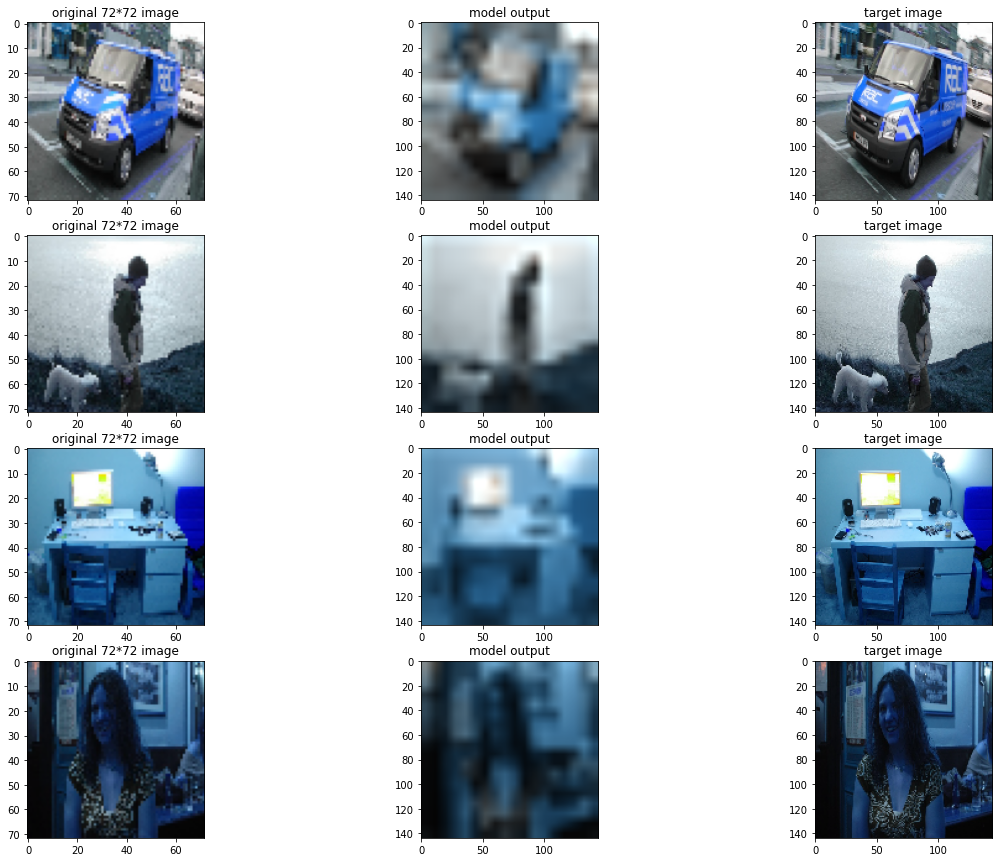

In [290]:
test_evaluation(test_loader,model,[criterion,l2,l1])